In [1]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, jacfwd, jacrev
from jax.scipy.linalg import inv, svd, eigh, det
from jax.lax import scan
from scipy.linalg import solve_discrete_are, norm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from jax.tree_util import Partial
from functools import partial
from jax_vi import KL_gaussian, log_likelihood, KL_sum, plot_optimization_results
from jax_filters import apply_filtering_fixed_nonlinear, kalman_filter_process, filter_step_nonlinear, ensrf_steps, kalman_filter_process
from jax_models import visualize_observations, Lorenz96, KuramotoSivashinsky, generate_true_states, generate_localization_matrix

# Parameters
F = 8.0
dt = 0.05
num_steps = 250  # Number of time steps

J0 = 0
n = 40   # Number of state variables
Q = 0.2 * jnp.eye(n)  # Process noise covariance
R = 0.5 * jnp.eye(n)  # Observation noise covariance
H = jnp.eye(n)  # Observation matrix

N = 10 # number of MC samples
n_ensemble = 30
observation_interval = 1
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state
m0 = initial_state
C0 = Q

l96_model = Lorenz96(dt = dt, F = F)
l96_step = Partial(l96_model.step)
state_transition_function = l96_step

jacobian_function = jacrev(l96_step, argnums=0)
jac_func = Partial(jacobian_function)
# Generate true states and observations using the Lorenz '96 model
key = random.PRNGKey(0)
observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)

In [3]:
# plt.pcolormesh(c[-1])
# plt.colorbar()

In [4]:
from jax_vi import KL_gaussian, log_likelihood, KL_sum

def var_cost(inflation, ensemble_init, observations, H, Q, R, localization_matrix, key, num_steps, J0):
    pred_states, pred_covar, states, covariances = ensrf_steps(l96_step, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    pred_mean = jnp.mean(pred_states, axis = -1)
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(pred_mean, pred_covar, ensemble_mean, covariances, n, l96_step, Q, key)

    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, ensemble_mean, covariances), observations, H, R, num_steps, J0)  
    cost = kl_sum - jnp.nanmean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    
    return cost

In [6]:
base_m, base_C, base_K  = kalman_filter_process(l96_step, jac_func, m0, C0, observations, H, Q, R)


In [8]:
from IPython.display import clear_output
from jax import grad
from tqdm.notebook import tqdm
import jax.numpy as jnp
from jax import random
import properscoring

var_cost_grad = grad(var_cost, argnums=0)

inflation_opt = 1.45 # Example starting value for inflation
radius = 16
alpha = 1e-6  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 20  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
localization_matrix = generate_localization_matrix(n, radius) 
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T

crpss = []
rmses=[]
inflations = []
true_div = []
covars = []

n_iters = 100


for i in tqdm(range(n_iters)):
    key, subkey = random.split(key)
        
    # Gradient descent step for inflation parameter
    grad_inflation = var_cost_grad(inflation_opt, ensemble_init, observations, H, Q, R, localization_matrix, subkey, num_steps, J0)
    inflation_opt -= alpha * grad_inflation  # Update inflation parameter
    inflations.append(inflation_opt)

    pred_states, pred_covariances, states, covariances = ensrf_steps(l96_step, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation_opt, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    rmse = jnp.sqrt(jnp.mean((ensemble_mean - true_states)**2))
    rmses.append(rmse)
    crps = properscoring.crps_ensemble(true_states, states).mean(axis=1).mean()
    crpss.append(crps)
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, ensemble_mean[t], covariances[t],  base_m[t], base_C[t])
        total_kl_divergence += kl_div_t
    true_div.append(total_kl_divergence / num_steps)
    covars.append(covariances)
    


  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:

@jit
def resample_particles(key, particles, weights):
    num_particles = particles.shape[0]
    cumulative_sum = jnp.cumsum(weights)
    indices = jnp.searchsorted(cumulative_sum, random.uniform(key, (num_particles,)))
    return particles[indices]

@jit
def update_weights(particles, observation, H, R):
    # Calculate the likelihood of each particle given the observation
    predicted_observations = jax.vmap(lambda x: jnp.dot(H, x), in_axes=0, out_axes=0)(particles)
    obs_dim = observation.shape[0]
    inv_R = jnp.linalg.inv(R)
    diff = observation - predicted_observations
    likelihood = jnp.exp(-0.5 * jax.vmap(lambda d: jnp.dot(d, jnp.dot(inv_R, d.T)), in_axes=0, out_axes=0)(diff))
    likelihood = likelihood / likelihood.sum()  # Normalize the weights
    return likelihood

@partial(jit, static_argnums=(1,2))
def particle_filter(key, num_particles, num_steps, initial_state, observations, observation_interval, state_transition_function, H, Q, R):
    mean = jnp.tile(initial_state, (num_particles, 1))
    particles = random.multivariate_normal(key, mean, Q, shape=(num_particles,))
    step = jax.vmap(state_transition_function, in_axes=0, out_axes=0)
    ensemble = []
    #for now we will assume observation_interval of 1
    def body_fn(carry, t):
        key, particles = carry
        key, subkey = random.split(key)
        # Transition particles to the next state
        particles = step(particles) + random.multivariate_normal(subkey, jnp.zeros(particles.shape[1]), Q, shape=(num_particles,))
        # Update weights and resample every step
        observation = observations[t]
        weights = update_weights(particles, observation, H, R)
        particles = resample_particles(subkey, particles, weights)
        return (key, particles), particles

    keys_and_particles = jax.lax.scan(body_fn, (key, particles), jnp.arange(num_steps))
    ensemble = keys_and_particles[1]
    return jnp.transpose(ensemble, (0, 2, 1))
    # Transpose to (timestep, state_dim, num_particles)

In [10]:
#from jax_filters import particle_filter
# import jax_filters
# import importlib
# importlib.reload(jax_filters)
num_particles = 20000
estimated_states = particle_filter(key, num_particles, num_steps, initial_state, observations, observation_interval, state_transition_function, H, Q, R)


In [11]:
covars[0].shape
def calculate_covariance_matrix(states):
    mean = jnp.mean(states, axis=2)
    deviations = states - mean[:, :, jnp.newaxis]
    covariance_matrix = jnp.einsum('ijk,ilk->ijl', deviations, deviations) / (states.shape[2] - 1)
    return covariance_matrix
particle_covars = calculate_covariance_matrix(estimated_states)

In [12]:
covar_diffs = []
for iter_covars in covars:
    frobenius_norms = jnp.array([jnp.linalg.norm(particle_covars[i] - iter_covars[i], 'fro') for i in range(num_steps)])
    covar_diffs.append(jnp.mean(frobenius_norms))


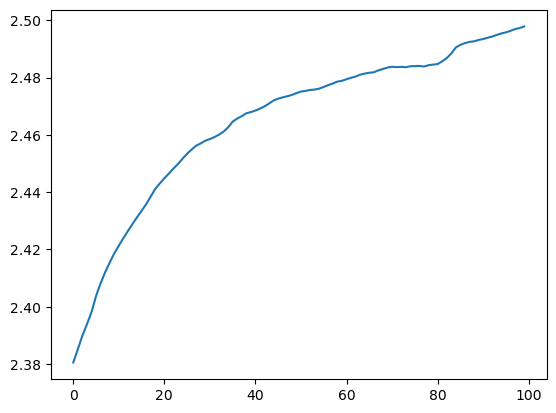

In [13]:
plt.plot(covar_diffs)

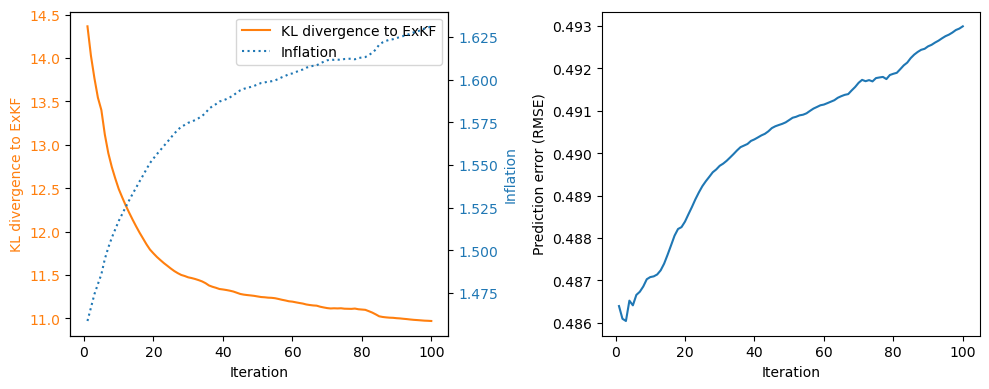

In [14]:
import matplotlib.pyplot as plt

fig, (ax1, ax3) = plt.subplots(figsize=(10, 4), ncols=2)

# Plotting the RMSE and CRPS on the primary y-axis
color = 'tab:orange'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('KL divergence to ExKF', color=color)
ln1 = ax1.plot(range(1, n_iters+1), true_div, label='KL divergence to ExKF', color='tab:orange', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin y-axis for the inflation parameter
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Inflation', color=color)
ln3 = ax2.plot(range(1, n_iters+1), inflations, label='Inflation', color=color, linestyle=':')
ax2.tick_params(axis='y', labelcolor=color)

# Combine legends from both axes
lns = ln1 + ln3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right')

ax3.plot(range(1, n_iters+1), rmses)
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Prediction error (RMSE)")

plt.tight_layout()
#plt.title('Inflation Parameter and Divergence from True Solution over Iterations')
#plt.show()
plt.savefig("inflation_errors.pdf")

In [ ]:
plt.pcolormesh(base_C[-1, :, :])

In [ ]:
plt.pcolormesh(covariances[-1])

In [ ]:
ins = []
cs = []
ds = []

for i in jnp.arange(1.0, 2.0, 0.01):
    states, covariances = ensrf_steps(l96_step, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, i, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, ensemble_mean[t], covariances[t],  m[t], C[t])
        total_kl_divergence += kl_div_t/num_steps

    c = var_cost(i, ensemble_init, observations, H, Q, R, localization_matrix, subkey, num_steps, J0)
    print(i, c, total_kl_divergence)
    cs.append(c)
    ds.append(total_kl_divergence)
    ins.append(i)

In [ ]:
plt.plot(cs)
plt.plot(jnp.array(ds)*300)

In [ ]:
plt.plot(ds[20:])